In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sstats

%matplotlib inline

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

## Przykładowe modele mutacji

In [58]:
sigmas = [np.array([[0.25 ** 2, 0.],[0., 0.25 ** 2]]),
         np.array([[0.25 ** 2, 0.],[0., 0.5 ** 2]]),
         np.array([[0.25, 0.25],[0.25, 0.5]]),
         'mut3 and tau']

In [59]:
def mutation(ind, N, d, S):
    return ind + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

## Algorytm ES

In [69]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, check_range=False, domain = (0,0), mutation_sigma = []):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = -np.Inf

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    
    if type(mutation_sigma) == str:
        current_population_sigmas = sigma * np.ones((population_size, 2, chromosome_length))
    else:
        current_population_sigmas = sigma * np.ones((population_size, chromosome_length))
            

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        if type(mutation_sigma) == str:
            children_population_sigmas = np.zeros((number_of_offspring, 2, chromosome_length))      
        else:
            children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
            
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        
        if len(mutation_sigma) > 0:
            if type(mutation_sigma) == str:
                children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, 2, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 2, 1))
                children_population_solutions = mutation(children_population_solutions, number_of_offspring, chromosome_length, children_population_sigmas)
            else:
                children_population_solutions = mutation(children_population_solutions, number_of_offspring, chromosome_length, mutation_sigma)
        else:
            # mutating the children population by adding random gaussian noise
            children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
            children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        
        if check_range:
            children_population_solutions[children_population_solutions < domain[0]] = domain[0]
            children_population_solutions[children_population_solutions > domain[1]] = domain[1]
        
        
        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

## Działanie ES na funkcjach sferycznych

## F1a

Iteration 0000 : best score = -5.05332959, mean score = -7422.83826019.
Iteration 0020 : best score = -0.00000010, mean score = -0.00042252.
Iteration 0040 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Best objective value: -1.48326261481498e-35


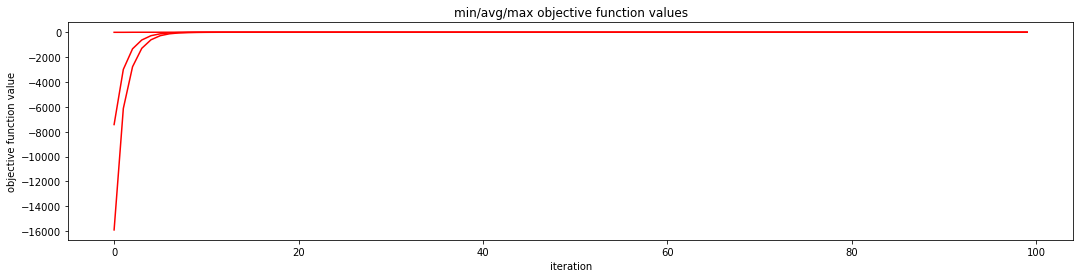

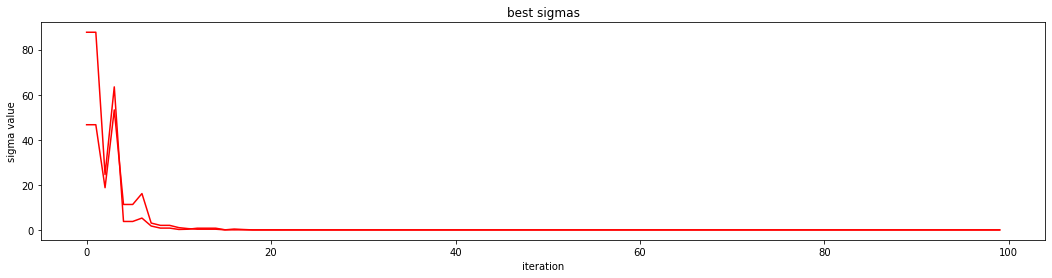

In [41]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -1.85686384, mean score = -6195.78477064.
Iteration 0020 : best score = -0.00002667, mean score = -0.06326432.
Iteration 0040 : best score = -0.00000076, mean score = -0.00461535.
Iteration 0060 : best score = -0.00000076, mean score = -0.00232364.
Iteration 0080 : best score = -0.00000076, mean score = -0.00157159.
Best objective value: -3.426359472928463e-07


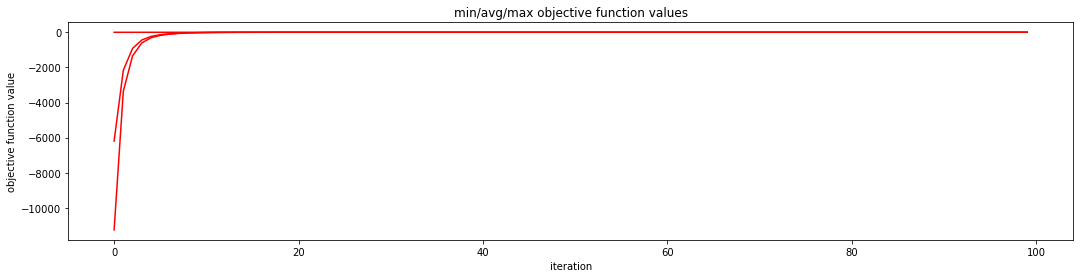

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [45]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[0])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -52.36940403, mean score = -6694.92635222.
Iteration 0020 : best score = -5.17902903, mean score = -9.81602392.
Iteration 0040 : best score = -0.00002528, mean score = -0.02284425.
Iteration 0060 : best score = -0.00000279, mean score = -0.00686063.
Iteration 0080 : best score = -0.00000279, mean score = -0.00389308.
Best objective value: -1.24648720018254e-07


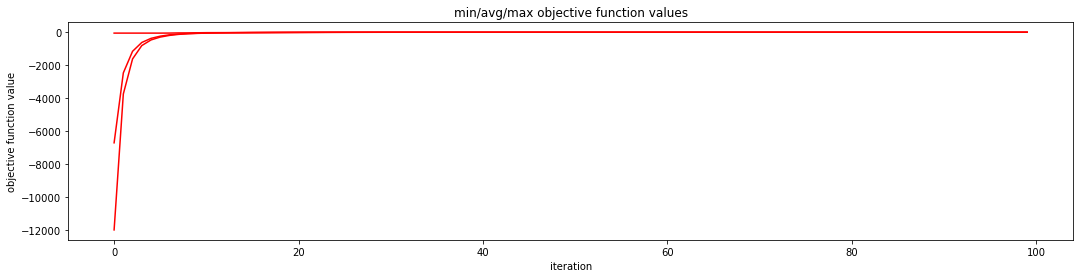

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [46]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[1])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -11.97801729, mean score = -6550.27265667.
Iteration 0020 : best score = -0.00006226, mean score = -0.25276453.
Iteration 0040 : best score = -0.00004989, mean score = -0.01891669.
Iteration 0060 : best score = -0.00000302, mean score = -0.00939693.
Iteration 0080 : best score = -0.00000302, mean score = -0.00632337.
Best objective value: -2.189158652868371e-06


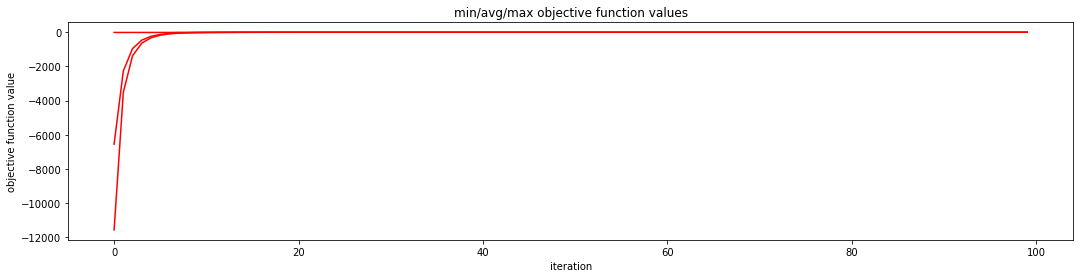

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [71]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[2])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

In [ ]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, sigmas[2], 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = 'mut and tau')

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

## F1b

Iteration 0000 : best score = -42.56745625, mean score = -240731.04582108.
Iteration 0020 : best score = -0.00003825, mean score = -0.03570119.
Iteration 0040 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Best objective value: -2.208606608201732e-34


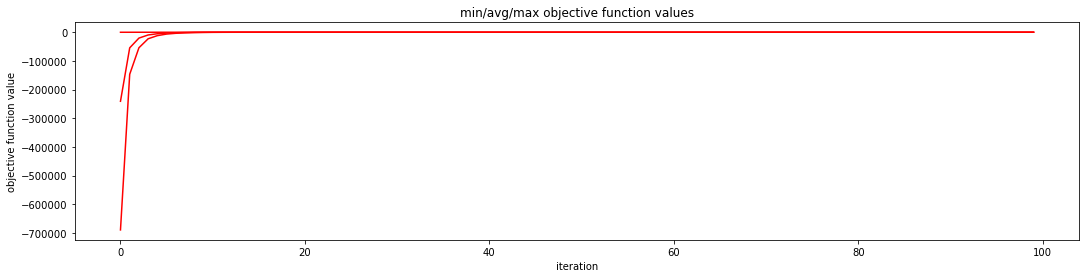

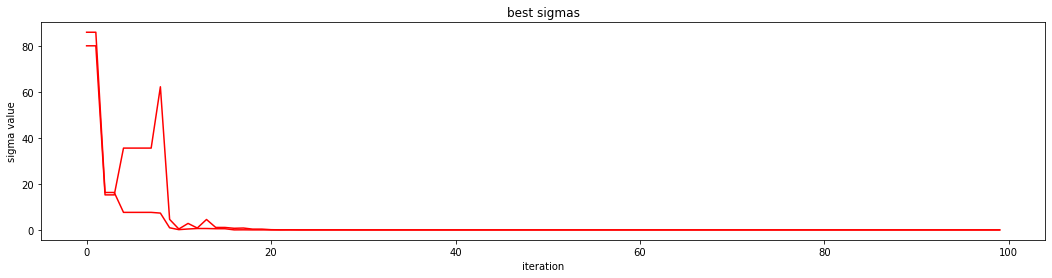

In [48]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -88.59347286, mean score = -237098.71604650.
Iteration 0020 : best score = -22.22466971, mean score = -33.09254402.
Iteration 0040 : best score = -1.64199729, mean score = -4.96638200.
Iteration 0060 : best score = -0.00025452, mean score = -0.27016082.
Iteration 0080 : best score = -0.00010469, mean score = -0.04229525.
Best objective value: -4.958412393872755e-05


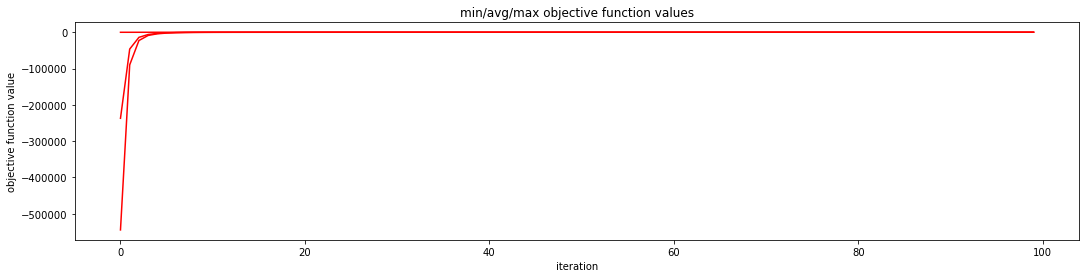

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [49]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[0])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -91.63848935, mean score = -248893.77745802.
Iteration 0020 : best score = -12.85407377, mean score = -35.37584649.
Iteration 0040 : best score = -3.47576841, mean score = -9.53106476.
Iteration 0060 : best score = -0.06821871, mean score = -2.16220855.
Iteration 0080 : best score = -0.00025147, mean score = -0.35522921.
Best objective value: -5.092592985081468e-05


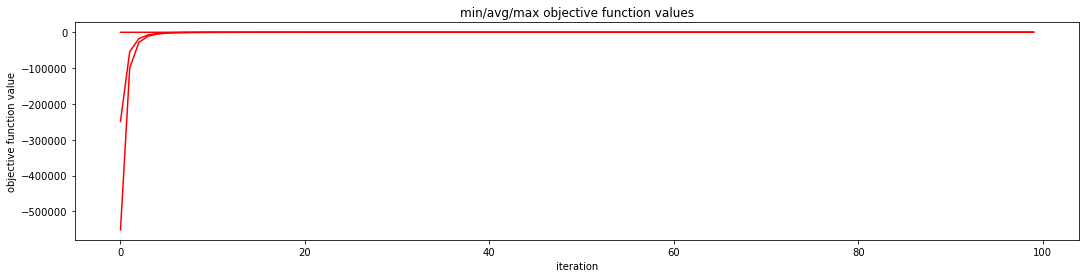

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [50]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[1])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -30.15160812, mean score = -228125.69570401.
Iteration 0020 : best score = -18.32376551, mean score = -45.75888192.
Iteration 0040 : best score = -3.71822494, mean score = -12.06173259.
Iteration 0060 : best score = -0.00214621, mean score = -2.41035919.
Iteration 0080 : best score = -0.00026353, mean score = -0.43561668.
Best objective value: -3.9408817731705746e-07


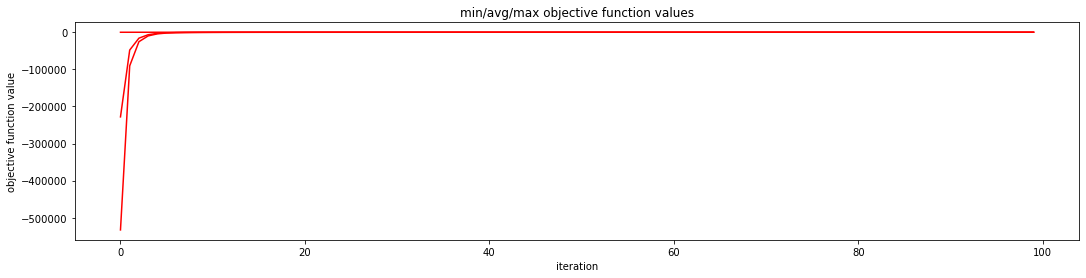

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [55]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[2])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

## F1c

Iteration 0000 : best score = -1.32292873, mean score = -1783.26647666.
Iteration 0020 : best score = -0.00000011, mean score = -0.00025733.
Iteration 0040 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Best objective value: -3.6684716207063893e-35


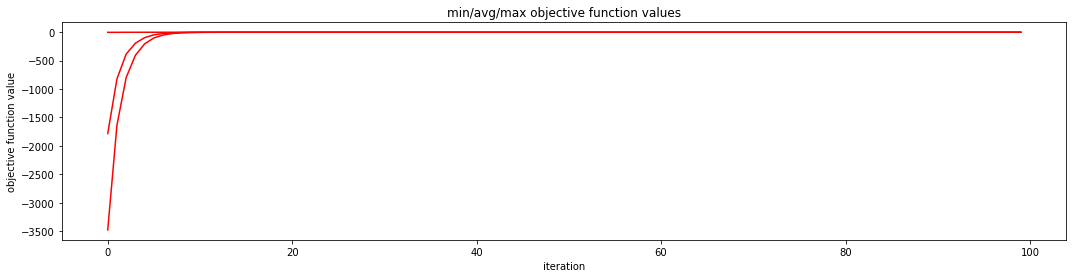

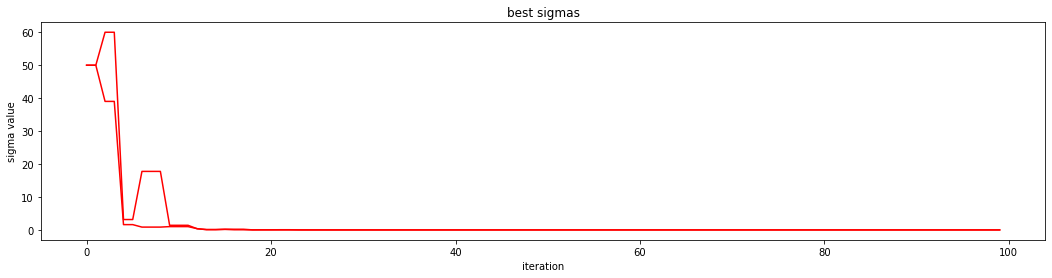

In [51]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -1.25732573, mean score = -1268.68806461.
Iteration 0020 : best score = -0.00025992, mean score = -0.06894687.
Iteration 0040 : best score = -0.00000198, mean score = -0.00157807.
Iteration 0060 : best score = -0.00000198, mean score = -0.00079444.
Iteration 0080 : best score = -0.00000198, mean score = -0.00053412.
Best objective value: -1.9776428804485065e-06


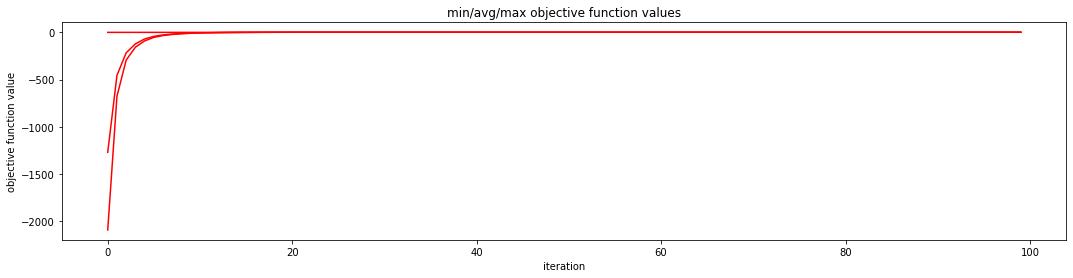

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [52]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[0])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -6.00568773, mean score = -1308.52894369.
Iteration 0020 : best score = -0.00001386, mean score = -0.08089398.
Iteration 0040 : best score = -0.00000408, mean score = -0.00316427.
Iteration 0060 : best score = -0.00000139, mean score = -0.00150362.
Iteration 0080 : best score = -0.00000139, mean score = -0.00100122.
Best objective value: -1.3913437629092465e-06


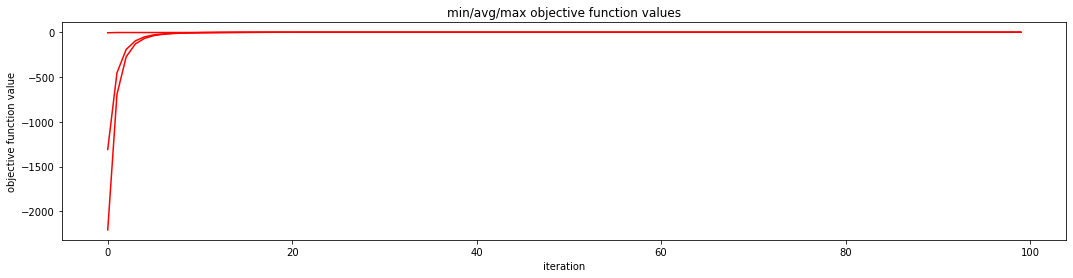

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [53]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[1])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''

Iteration 0000 : best score = -10.51518027, mean score = -1261.66995339.
Iteration 0020 : best score = -0.00003934, mean score = -0.02420012.
Iteration 0040 : best score = -0.00002311, mean score = -0.00514817.
Iteration 0060 : best score = -0.00000159, mean score = -0.00288717.
Iteration 0080 : best score = -0.00000159, mean score = -0.00193947.
Best objective value: -1.585672501898383e-06


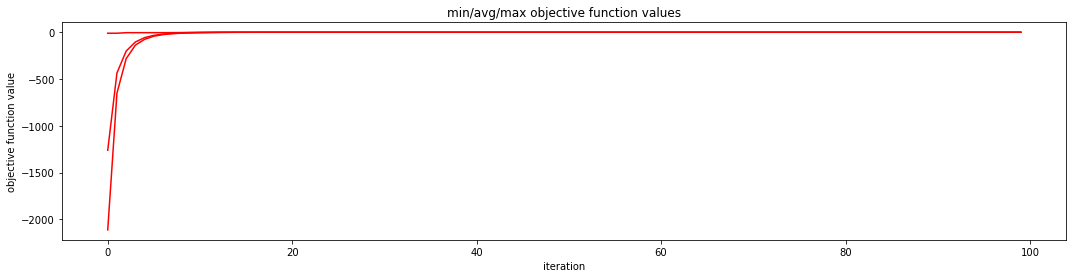

"plt.figure(figsize=(18, 4))\nplt.plot(history_best_sigmas, 'r-')\nplt.xlabel('iteration')\nplt.ylabel('sigma value')\nplt.title('best sigmas')\nplt.show()"

In [54]:
d = 2
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20, mutation_sigma = sigmas[2])

print("Best objective value:", best_objective_value)
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

'''plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()'''